## PU learning

In [1]:
from scipy import signal
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

In [2]:
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

### Data Creating

Let's create some syntetic data based on gaussian windows.

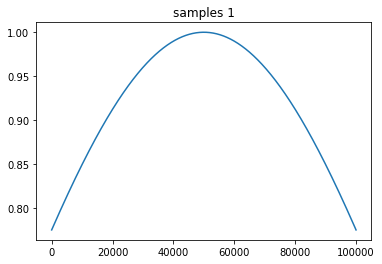

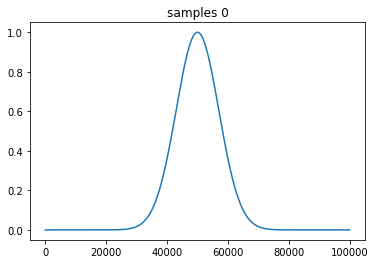

In [3]:
gaussian_arr = signal.gaussian(100000, std=70000)
plt.plot(gaussian_arr)
plt.title("samples 1")
plt.show()
laplaccian_arr = signal.gaussian(100000, std=7000) #signal.gaussian(100000, std=7000)#
plt.plot(laplaccian_arr)
plt.title("samples 0")
plt.show()

Mixing the datas to dataframe with correct labels

In [4]:
df = pd.DataFrame(data=np.vstack((np.stack(
    (gaussian_arr, [1]*len(gaussian_arr)), axis=-1),np.stack((laplaccian_arr, [0]*len(laplaccian_arr)), axis=-1))), 
    columns=["x", "y"]) #1 - for gaussian 0 - for laplaccian

Suffling whole data.

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,x,y
0,5.333082e-08,0.0
1,9.386219e-01,0.0
2,8.572715e-01,1.0
3,9.864227e-01,1.0
4,8.901194e-01,1.0


### Normal classifier, normal data example

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["x"], df["y"], test_size=0.33, random_state=42)

As an exaple of classifier i would use Random Forest classifier from sklearn lib, course it one of the mentioned classifiers in article and can be easily replaced with any other from sklearn with no code changes.

In [8]:
classifier = RandomForestClassifier
params = {"n_estimators":100, "max_depth":2, "random_state":0}
# calssifier = LogisticRegression
# params = {"solver":'lbfgs'}

In [9]:
CL_ex = classifier(**params)
CL_ex.fit(X_train.values.reshape(-1, 1), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [10]:
y_pred = CL_ex.predict(X_test.values.reshape(-1, 1))
print(f"acc is {accuracy_score(y_test, y_pred):.4f}, "
      f"f1 is {f1_score(y_test, y_pred):.4f}, "
      f"roc is {roc_auc_score(y_test, y_pred):.4f}")

acc is 0.9511, f1 is 0.9534, roc is 0.9510


Let's make some of the data undefined.

In [11]:
df["s"] = df["y"] * np.random.randint(0,2,len(df))

In [12]:
df.head()

,x,y,s
0,5.333082e-08,0.0,0.0
1,9.386219e-01,0.0,0.0
2,8.572715e-01,1.0,0.0
3,9.864227e-01,1.0,1.0
4,8.901194e-01,1.0,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df["x"], df[["s","y"]], test_size=0.33, random_state=42)

In [14]:
CL_ex = classifier(**params)
CL_ex.fit(X_train.values.reshape(-1, 1), y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Ordinary classifier works bad with undefined data - it can't learn unreal dependense (will the value be def or undef) and can't learn real dependense - undefined data mixes everething two much.

In [15]:
CL_ex.predict(X_test.values.reshape(-1, 1))
print(f"Score for s is {CL_ex.score(X_test.values.reshape(-1, 1),y_test['s']):.4f}, course unreal dependense is hard to learn")
print(f"Score for y is {CL_ex.score(X_test.values.reshape(-1, 1),y_test['y']):.4f} course real dependense is hard to learn from unreal")

Score for s is 0.7468, course unreal dependense is hard to learn
Score for y is 0.4993 course real dependense is hard to learn from unreal


Let's build classifier, that would cope with defined-undefined data.

### Divide data

In [16]:

X_train, X_test, y_train, y_test = train_test_split(df["x"], df[["s", 'y']], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

### Fit g classificator

In [17]:
CL_g = classifier(**params)
CL_g.fit(X_train.values.reshape(-1, 1), y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Estimating c

As written in article c is probability that if data is type 1 - it will be defined data that can be estimated via classifier g, builded on Def/Undef data

There are three ways to estimate c, described in article.

In [18]:
X_val_p = X_val.loc[X_val.index[y_val["s"] == 1]]
d_p = CL_g.predict_proba(X_val_p.values.reshape(-1, 1))[:,1]
e1 = d_p.sum()/len(X_val_p)
e1

0.45321640767393606

In [19]:
d_v = CL_g.predict_proba(X_val.values.reshape(-1, 1))[:,1]
e2 = d_p.sum()/d_v.sum()
e2

0.44957024642231547

In [20]:
e3 = d_v.max()
e3

0.4594899767649901

### First way to create f classificator

###### IT IS NOT THE PART OF ARTICLE
While i was reading article, i had an idea that classifier could be easily improved with deviding result on c.

In [21]:
CL_f = classifier(**params)
CL_f.fit(X_train.values.reshape(-1, 1), y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
c = e1 # e2 or e3
y_pred = np.array(CL_f.predict_proba(X_test.values.reshape(-1,1))[:,1]/c > 0.5, dtype=int)
accuracy_score(y_test["y"],y_pred)

0.9510909090909091

### Second way to improve classifier f

The way, that was used by the authors of article is to create weights of each sample build on g prediction for value and parametr c.

In [23]:
def create_new_train(e, X_train, y_train, CL):
    X_train_new = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 1]])
    X_train_new["w"] = 1
    y_train_new = pd.DataFrame([1]*len(X_train_new), columns=["s"])
    X_train_1 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_1["x"].values.reshape(-1,1))[:,1]
    X_train_1["w"] = (1-e)/e * g_x/(1-g_x)
    y_train_1 = pd.DataFrame([1]*len(X_train_1), columns=["s"])
    X_train_2 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_2["x"].values.reshape(-1,1))[:,1]
    X_train_2["w"] = 1 - (1-e)/e * g_x/ (1-g_x)
    y_train_2 = pd.DataFrame([0]*len(X_train_2), columns=["s"])
    X_train_new = X_train_new.append(X_train_1, ignore_index=True, sort=False)
    X_train_new = X_train_new.append(X_train_2, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_1, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_2, ignore_index=True, sort=False)
    return X_train_new, y_train_new

#### e1

In [24]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e1, X_train, y_train, CL_g)
CL_f.fit(X_train_new['x'].values.reshape(-1, 1), y_train_new["s"], sample_weight=X_train_new['w'])
y_pred = CL_f.predict(X_test.values.reshape(-1, 1))
print(f"acc is {accuracy_score(y_test['y'], y_pred):.4f}, "
      f"f1 is {f1_score(y_test['y'], y_pred):.4f}, "
      f"roc is {roc_auc_score(y_test['y'], y_pred):.4f}")

acc is 0.9511, f1 is 0.9534, roc is 0.9510


#### e2

In [25]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e2, X_train, y_train, CL_g)
CL_f.fit(X_train_new['x'].values.reshape(-1, 1), y_train_new["s"], sample_weight=X_train_new['w'])
y_pred = CL_f.predict(X_test.values.reshape(-1, 1))
print(f"acc is {accuracy_score(y_test['y'], y_pred):.4f}, "
      f"f1 is {f1_score(y_test['y'], y_pred):.4f}, "
      f"roc is {roc_auc_score(y_test['y'], y_pred):.4f}")

acc is 0.9511, f1 is 0.9534, roc is 0.9510


#### e3

In [26]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e3, X_train, y_train, CL_g)
CL_f.fit(X_train_new['x'].values.reshape(-1, 1), y_train_new["s"], sample_weight=X_train_new['w'])
y_pred = CL_f.predict(X_test.values.reshape(-1, 1))
print(f"acc is {accuracy_score(y_test['y'], y_pred):.4f}, "
      f"f1 is {f1_score(y_test['y'], y_pred):.4f}, "
      f"roc is {roc_auc_score(y_test['y'], y_pred):.4f}")

acc is 0.9511, f1 is 0.9534, roc is 0.9510


It can be noticed that on suntetic data all estimation of c is nearly equal.

In [44]:
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

In [45]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [46]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [47]:
# Let's say that 8 - is positive and all other is negative class
digits.target = np.array(digits.target==8, dtype=int)

In [56]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
classifier.fit(data[:3*n_samples // 4], digits.target[:3*n_samples // 4])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
# Now predict the value of the digit on the second half:
expected = digits.target[3*n_samples // 4:]
predicted = classifier.predict(data[3*n_samples // 4:])

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       409
           1       1.00      0.83      0.91        41

    accuracy                           0.98       450
   macro avg       0.99      0.91      0.95       450
weighted avg       0.98      0.98      0.98       450


Confusion matrix:
[[409   0]
 [  7  34]]


In [59]:
# Lets create labeled/unlabled data
digits["s"] = np.random.randint(0,2, len(digits.target))*digits.target

In [62]:
sum(digits.s), sum(digits.target)

(81, 174)

In [98]:
# Create a classifier: a support vector classifier
CL_g = svm.SVC(gamma=0.001, probability=True)

# We learn the digits on the first half of the digits
CL_g.fit(data[:3*n_samples // 4], digits.s[:3*n_samples // 4])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [99]:
# Now predict the value of the digit on the second half:
expected = digits.target[3*n_samples // 4:]
predicted = CL_g.predict(data[3*n_samples // 4:])

print("Classification report for classifier %s:\n%s\n"
      % (CL_g, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       409
           1       1.00      0.05      0.09        41

    accuracy                           0.91       450
   macro avg       0.96      0.52      0.52       450
weighted avg       0.92      0.91      0.88       450


Confusion matrix:
[[409   0]
 [ 39   2]]


In [100]:
len(data), len(digits.target)

(1797, 1797)

In [101]:
x_columns = ["x"+str(i) for i in range(len(data[0]))]
df = pd.DataFrame(data, columns=x_columns)
df["y"] = digits.target
df["s"] = digits.s

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df[x_columns], df[["s", 'y']], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [111]:
def create_new_train(e, X_train, y_train, CL):
    X_train_new = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 1]])
    X_train_new["w"] = 1
    y_train_new = pd.DataFrame([1]*len(X_train_new), columns=["s"])
    X_train_1 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_1[x_columns])[:,1]
    print(len(X_train), len(g_x))
    X_train_1["w"] = (1-e)/e * g_x/(1-g_x)
    y_train_1 = pd.DataFrame([1]*len(X_train_1), columns=["s"])
    X_train_2 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_2[x_columns])[:,1]
    X_train_2["w"] = 1 - (1-e)/e * g_x/ (1-g_x)
    y_train_2 = pd.DataFrame([0]*len(X_train_2), columns=["s"])
    X_train_new = X_train_new.append(X_train_1, ignore_index=True, sort=False)
    X_train_new = X_train_new.append(X_train_2, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_1, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_2, ignore_index=True, sort=False)
    return X_train_new, y_train_new

In [112]:
X_val_p = X_val.loc[X_val.index[y_val["s"] == 1]]
d_p = CL_g.predict_proba(X_val_p)[:,1]
e1 = d_p.sum()/len(X_val_p)
print(f"e1 = {e1}")
d_v = CL_g.predict_proba(X_val)[:,1]
e2 = d_p.sum()/d_v.sum()
print(f"e2 = {e2}")
e3 = d_v.max()
print(f"e3 = {e3}")

e1 = 0.3474581495030847
e2 = 0.3270063273211179
e3 = 0.986696597706602


In [114]:
CL_f =  svm.SVC(gamma=0.001, probability=True)
X_train_new, y_train_new = create_new_train(e2, X_train, y_train, CL_g)
CL_f.fit(X_train_new[x_columns], y_train_new["s"], sample_weight=X_train_new['w'])

806 762


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [121]:
expected = y_test["y"]
predicted = CL_f.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       542
           1       1.00      0.46      0.63        52

    accuracy                           0.95       594
   macro avg       0.98      0.73      0.80       594
weighted avg       0.96      0.95      0.94       594


Confusion matrix:
[[542   0]
 [ 28  24]]
